Multivariate Vanilla-LSTM with X variables transformed and y variable raw


In [ ]:
# Selecting v1.15 of tf
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
# Checking that I use the correct version
print(tensorflow.__version__)

1.15.2


In [ ]:
# Connect to gdrive to read csv file
from google.colab import drive
# Set force_remount=True to ensure any changed file is mounted
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Import libraries and useful functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

#To display all columns/rows in the dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data
df=pd.read_csv('/content/gdrive/My Drive/stock_pred/final_dataset.csv',
               sep = ';',
               index_col='Date')

df.index=pd.to_datetime(df.index)

In [ ]:
# Some pre-processing
df = df.fillna(method='bfill')

In [ ]:
# Train-Val-Test Split

import datetime as dt
import time

series=df

train_start = dt.date(2008,8,8)
train_end = dt.date(2013,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2014,1,1)
val_end = dt.date(2015,3,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2015,4,1)
test_end = dt.date(2016,6,30)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(1359, 23) (313, 23) (315, 23)


In [ ]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train = scaler.fit_transform(train_data)
val = scaler.transform(val_data)
test = scaler.transform(test_data)
print(train.shape,val.shape,test.shape)

(1359, 23) (313, 23) (315, 23)


In [ ]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

# Look at last 21 days, predict the 22nd
seq_length = 21

# Loop for training data
for i in range(seq_length,train.shape[0]):
    X_train.append(train[i-seq_length:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for validation data
for i in range(seq_length,val.shape[0]):
    X_val.append(val[i-seq_length:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

# Loop for testing data
for i in range(seq_length,test.shape[0]):
    X_test.append(test[i-seq_length:i])
    Y_test.append(test[i][0])
X_test,Y_test = np.array(X_test),np.array(Y_test)

In [ ]:
# Define the LSTM model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

lr=0.01
epochs=100
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

model = Sequential()
model.add(LSTM(256, activation='sigmoid',
               input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


[INFO] training model...

Train on 1338 samples, validate on 292 samples
Epoch 1/100
1338/1338 [==============================] - 3s 2ms/step - loss: 1.6352 - val_loss: 0.3448
Epoch 2/100
1338/1338 [==============================] - 1s 549us/step - loss: 0.0340 - val_loss: 0.4007
Epoch 3/100
1338/1338 [==============================] - 1s 555us/step - loss: 0.0313 - val_loss: 0.4006
Epoch 4/100
1338/1338 [==============================] - 1s 560us/step - loss: 0.0296 - val_loss: 0.3856
Epoch 5/100
1338/1338 [==============================] - 1s 545us/step - loss: 0.0278 - val_loss: 0.3607
Epoch 6/100
1338/1338 [==============================] - 1s 559us/step - loss: 0.0258 - val_loss: 0.3456
Epoch 7/100
1338/1338 [==============================] - 1s 549us/step - loss: 0.0237 - val_loss: 0.2991
Epoch 8/100
1338/1338 [==============================] - 1s 557us/step - loss: 0.0212 - val_loss: 0.2412
Epoch 9/100
1338/1338 [==============================] - 1s 554us/step - loss: 0.0186 - v

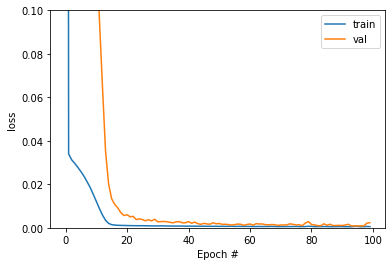

In [ ]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
plt.ylim(top=0.1,bottom=0)
plt.show()

In [ ]:
# Need to denormalize the target variable in all the sets

## Train
y_train_min = train_data.min()[0]
y_train_max = train_data.max()[0]
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()[0]
y_val_max = val_data.max()[0]
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()[0]
y_test_max = test_data.max()[0] 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [ ]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.5245635224350286
MSE (validation): 0.5028161683099558
MSE (test): 2.253139175005114


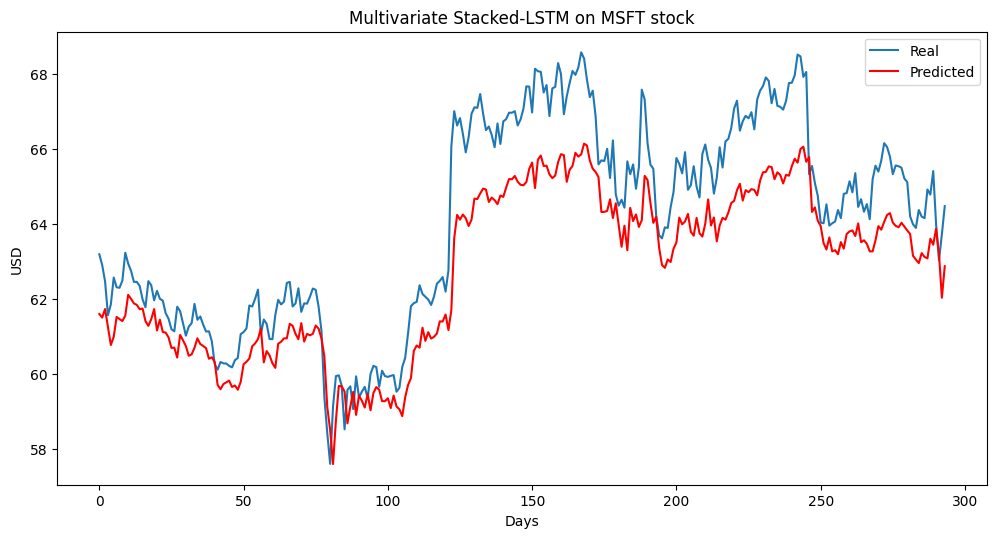

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Multivariate Stacked-LSTM on MSFT stock')
plt.legend()
plt.show()

Let's apply hyperparameter optimization, and see can I achieve:

In [ ]:
import sys
import time
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

# Will use Hyper-Opt to find the optimum parameters for the regressor

#Will set an EarlyStopping callback:
# - [monitor]: look at validation loss
# - [min_delta]: quantify the loss amount
# - [patience]: nr of epochs before stopping
# - [verbose]: what to print
# - [mode]: the direction we want to track (e.g. min, max)

def get_callbacks(pars):
  callbacks = [EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0.001, 
                             patience = 2, 
                             verbose= 0, 
                             mode = 'auto')]
  return callbacks

# Defining the space in which fmin() will iterate:

space = {'neurons': hp.choice('neurons', [64, 128, 256]),
         'lr': hp.choice('lr',[0.1, 0.01, 0.001]),
         'activation_fn': hp.choice('activation_fn',['sigmoid','tanh','relu'])
        }

def my_vanilla_LSTM(pars):
  print('Parameters: ', pars)

  # Define the 2 neuron layers
  model = Sequential()
  model.add(LSTM(pars['neurons'], 
                 activation = pars['activation_fn'],
                 input_shape=(X_train.shape[1], X_train.shape[2])))
  
  # Last unique linear activation for regression
  model.add(Dense(1, activation = 'linear'))

  # Define optimizer with learning rate as optimizable parameter 
  opt = Adam(lr = pars['lr'], decay = pars['lr'])
  
  # Compile the model
  model.compile(optimizer = opt, loss = 'mean_squared_error')

  # We now train the model
  history = model.fit(x=X_train, 
                      y=Y_train, 
					            validation_data=(X_val, Y_val),
	                    epochs = 10, 
                      batch_size = 32,
                      callbacks = get_callbacks(pars))
  
  # Save the losses and print them
  best_epoch_loss = np.argmin(history.history['val_loss'])
  best_val_loss = np.min(history.history['val_loss'])
  print('Epoch {} -  val loss: {}'.format(best_epoch_loss, best_val_loss))
  
  #This will let us see the progress while the script is running
  sys.stdout.flush()

  return {'loss': best_val_loss, 'best_epoch': best_epoch_loss, 
          'eval_time': time.time(), 'status': STATUS_OK, 'model': model, 
          'history': history}

trials = Trials()
# Use of fmin(), in which we put: 
#   - the defined function to minimize, 
#   - our space to iterate
#   - algorithm used: Tree of Parsen Estimators (TPE)
#   - maximum nr of evaluations 
#   - trials are used to see the results of each evaluation
best = fmin(my_vanilla_LSTM, space, algo = tpe.suggest, max_evals = 10, trials = trials)
print(best)

Parameters: 
{'activation_fn': 'tanh', 'lr': 0.1, 'neurons': 256}
Train on 1338 samples, validate on 292 samples
Epoch 1/10
  32/1338 [..............................]
 - ETA: 10s - loss: 0.4438

 128/1338 [=>............................]
 - ETA: 3s - loss: 121.5171

 224/1338 [====>.........................]
 - ETA: 1s - loss: 88.9893 

 320/1338 [======>.......................]
 - ETA: 1s - loss: 79.4651

 416/1338 [========>.....................]
 - ETA: 1s - loss: 63.2603

 512/1338 [==========>...................]
 - ETA: 0s - loss: 52.1378

 608/1338 [============>...............

In [ ]:
trials.losses()

[0.2478341323463884,
 0.34300592460044443,
 0.013149778505353487,
 0.0052241932495883095,
 0.012865832955767847,
 0.002088050103637913,
 3.284336401477191e+29,
 0.02002064109307854,
 0.052758733397477296,
 0.36492063370469496]

In [ ]:
trials.trials[5]

{'book_time': datetime.datetime(2020, 8, 6, 2, 42, 20, 202000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'activation_fn': [5], 'lr': [5], 'neurons': [5]},
  'tid': 5,
  'vals': {'activation_fn': [1], 'lr': [2], 'neurons': [2]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 8, 6, 2, 42, 25, 784000),
 'result': {'best_epoch': 3,
  'eval_time': 1596681745.7847147,
  'history': <keras.callbacks.callbacks.History at 0x7f4cc698f7b8>,
  'loss': 0.002088050103637913,
  'model': <keras.engine.sequential.Sequential at 0x7f4cc6a65e48>,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 5,
 'version': 0}

In [ ]:
lr=0.001
epochs=400
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

model = Sequential()
model.add(LSTM(256, activation='sigmoid',
               input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

[INFO] training model...
Train on 1338 samples, validate on 292 samples
Epoch 1/400
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0495 - val_loss: 0.3361
Epoch 2/400
1338/1338 [==============================] - 1s 567us/step - loss: 0.0199 - val_loss: 0.2595
Epoch 3/400
1338/1338 [==============================] - 1s 575us/step - loss: 0.0115 - val_loss: 0.0509
Epoch 4/400
1338/1338 [==============================] - 1s 574us/step - loss: 0.0048 - val_loss: 0.0122
Epoch 5/400
1338/1338 [==============================] - 1s 565us/step - loss: 0.0020 - val_loss: 0.0058
Epoch 6/400
1338/1338 [==============================] - 1s 570us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/400
1338/1338 [==============================] - 1s 561us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/400
1338/1338 [==============================] - 1s 568us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/400
1338/1338 [==============================] - 1s 565us/step - loss: 0.0018 - va

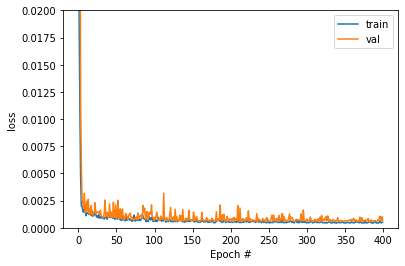

In [ ]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
plt.ylim(top=0.02,bottom=0)
plt.show()

In [ ]:
# Need to denormalize the target variable in all the sets

## Train
y_train_min = train_data.min()[0]
y_train_max = train_data.max()[0]
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()[0]
y_val_max = val_data.max()[0]
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()[0]
y_test_max = test_data.max()[0] 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [ ]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.32659836129579567
MSE (validation): 0.1464202057488171
MSE (test): 0.3570750497050654


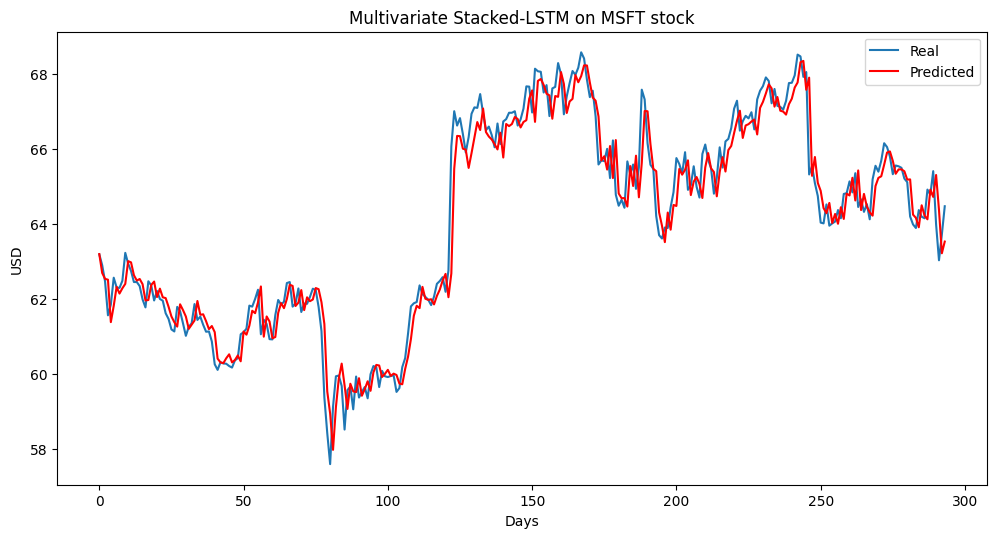

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Multivariate Vanilla-LSTM w/ Hyperparameter Optimization on MSFT stock')
plt.legend()
plt.show()